# Transformer를 활용한 챗봇

## 개념 정리

### 1. seq2seq

: 기존 context vector(각각의 hidden sate 각 단어에 대한 정보에 대한 값) v에 "고정된 크기로" 소스 문장의 정보를 압축해야해서 병목(bottleneck)이 발생하여 성능 하락이되었음.

인코더의 마지막 hidden state값이 context vector로 사용되었는데, 디코더에서 출력단어가 들어올때마다 context vector로부터 출발해서 또다른 hidden state s값을 만들었음. 이렇게 각각 만들면서 문장이 끝날 때 End of sequence(EOS)까지 반복함.(인코더와 디코더는 서로 다른 가중치를 가짐)

이를 개선하기 위해 고정된 Vector를 디코더 각각의 RNN에서 참고하게 만듬(손실정보를 줄이기위함) but 인코더부분에서 고정된 vector에다가 값을 저장한다는 것은 변함이 없으므로 크게 개선이 없었음.

이를 개선하기 위해 Seq2seq with Attention이 나옴. 

매번 인코더의 소스문장에서의 출력 전부를 특정행렬에 기록했다가 소스전반에 대한 내용들을 입력으로 받게 하며, 이에 디코더에서는 고정된 context vector만 참고하는 것이아닌 인코더에서 출력된 hidden 값들을 (인코더에서 받은 단어에 히든스테이트에 (softmax)확률값을 구하고 이것을 가중치로 이용하여 이것을 각각 소스문장의 히든스테이트값을 곱하고 다 더하여 디코더의 입력으로 사용함)전부 반영하여 어떤 단어에 더 집중하여 출력결과를 만들수 있는가를 모델이 고려하게 만듬.

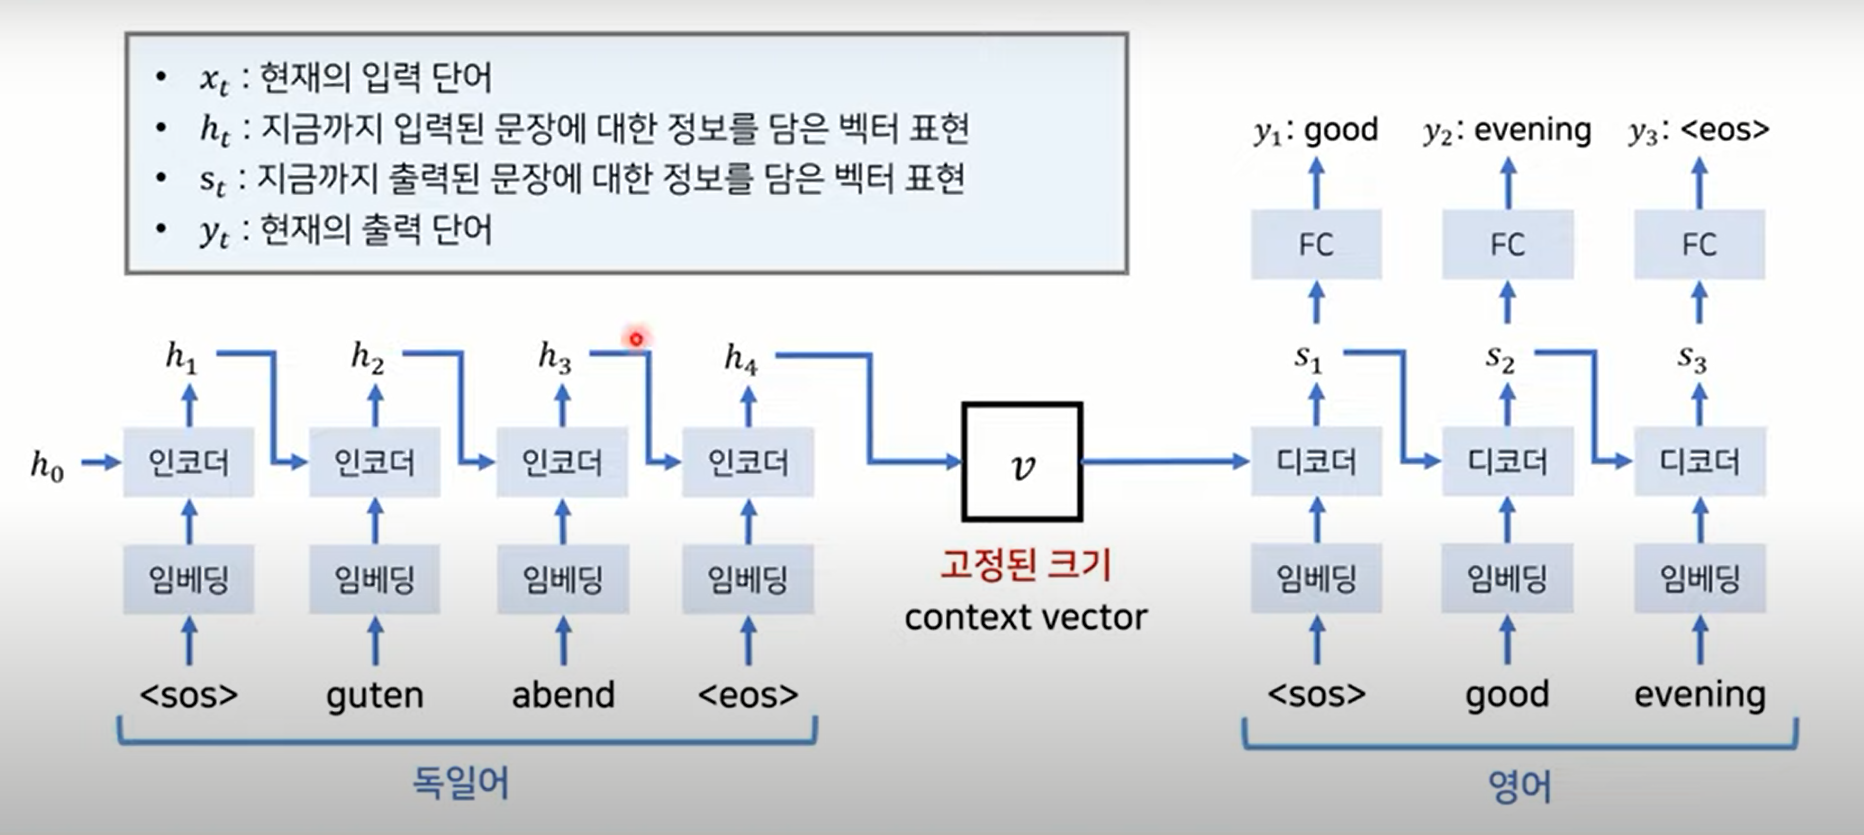


### Transformer
:초록색 색깔의 도형을 인코더 층(Encoder layer), 핑크색 색깔의 도형을 디코더(Decoder layer)라고 하였을 때, 입력 문장은 누적해 쌓아 올린 인코더의 층을 통해서 정보를 뽑아내고, 디코더는 누적해 쌓아 올린 디코더의 층을 통해서 출력 문장의 단어를 하나씩 만들어가는 구조임.

https://nlpinkorean.github.io/illustrated-transformer/

I am a student 라는 문장이 입력되면 embedding matrix형태로 만들게 되는데 단어의 갯수만큼 행이 만들어지고, 열은 임베딩차원과 같게 갯수가 만들어짐. 그런 다음 각각의 임베딩값(embedding dimension)을 구하게되는데 이때, input embedding matrix와 같은 크기에 위치에 대한 정보를 가지는 positional encoding에 더해줌. 이로써 네트워크가 각각의 단어가 어떤 순서를 가지는지 인식하게 할 수 있음.

그런 다음, Multi-head attention을 거치게 되는데, 인코더 어텐션(self attention)으로서 각 각의 단어가 서로에 대해 어떤 연관성을 가지는지 attention score를 구해서 학습시키게되고, residual learning(잔여학습)이 같이 이용되는데, 이 것은 특정레이어를 건너뛰어서 복사가 된 값을 그대로 넣어주는 기법을 사용함.(residual connection) - 그림에서 Add+Norm부분

이렇게하면 기존정보를 입력받으면서,추가적으로 잔여된 부분만 학습하게 만들기때문에 초기 모델 수렴속도가 높아짐(global optima를 찾을 가능성이 높아짐) 그 다음, normalization을 시행하고 결과를 내보냄. 이 값들은 feedforward layer를 거치고 Add+Nor 과정을 한번 더 거치게됨. 이렇게 한 레이어 과정을 거치면서 여러 레이어(n개)를 중첩하게 됨. 이때 각각의 레이어는 서로 다른 parameter를 가지게 되는데, 각 레이어를 거칠때 입력할때 dimension과 출력되서 다시 들어가는 dimension은 같음. 최종레이어에서 출력값은 디코더의 Multi-head attention으로 가게 되는데(다른 트랜스포머 모델은 각각의 입력값을 받는 기법도 존재함) 이렇게 하는 이유는 디코더에서 매번 출력할 때마다 입력소스 문장중에서 어떤 단어에게 더 초점을 둬야되는지 알려주기 위함임.

디코더에서는 두개의 어텐션이 존재하고 

첫번째는 Masked Decoder self attention임. 디코더의 각각의 출력단어가 인코더의 self attention과 같이 모두 참고하는게 아니라, 앞쪽에 등장했던 단어만 참고하도록함. ex) "나는 축구를 했다"에서 축구를 이라는 단어가 출력될 때 "나는" 이라는 단어를 참고하도록 함.출력 단어 각각 서로에 대해서 어떠한 가중치를 가지는지 구하게 만들어서 문장 전반적인 표현을 학습하도록 만듬. 


두번째 Encoder-Decoder attention 레이어에서는 인코더에서 나온 값들을 attention하게 함. 즉, 쿼리가 뒷부분에 있고 키와 벨류는 인코더에서 참고함. 이렇게하면 각각 출력되는 단어가 소스문장에서의 어떤단어와 연관성을 구할 수 있음.디코더 또한, 디코더에서 입력으로 들어온 dimension과 출력 dimension을 같게 만들어서  각각 디코더레이어는 중첩되서 사용할 수 있음. -> 트랜스포머에서는 마지막 인코더 레이어의 출력이 모든 디코더레이어에 입력이 됨. 아래 그림은 n_layers=4일 때의 예시임 

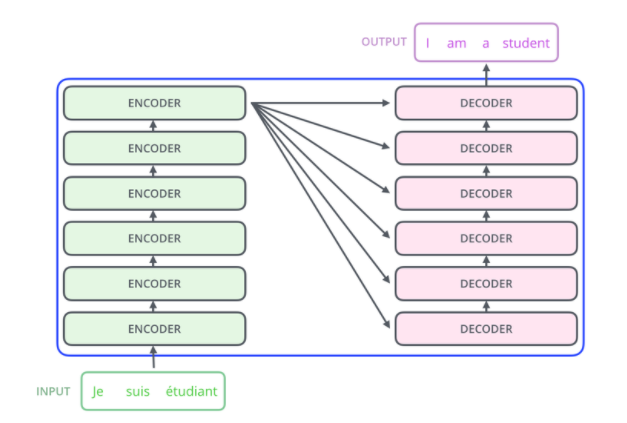

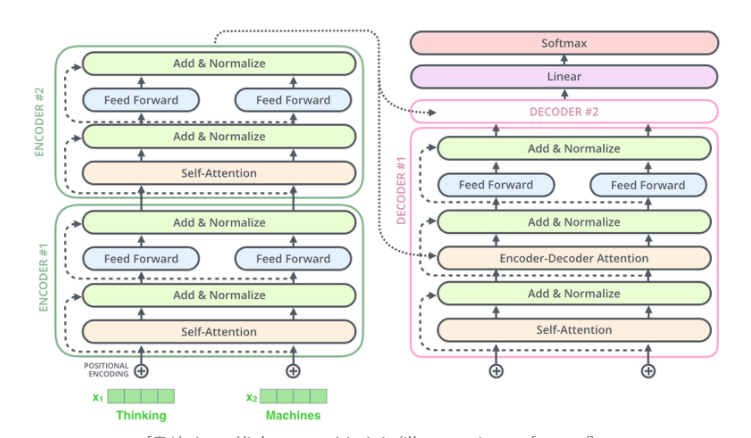

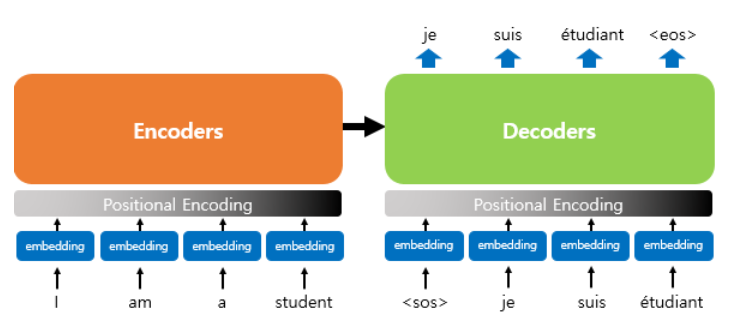

### Positional Encoding 에대한 내용 보충
: 많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거침. 트랜스포머 또한 그러한 방식을 거치며, 단지 다른 점은, 트랜스포머 모델의 입력 데이터 처리는 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점임. 그 값은 바로 위 그림에서의 포지셔널 인코딩(positional Encoding)에 해당하는 부분이며,

이렇게 해주는 이유는 트랜스포머는 입력을 받을 때, 문장에 있는 단어들을 1개씩 순차적으로 받는 것이 아니라, 문장에 있는 모든 단어를 한꺼번에 입력으로 받기 때문

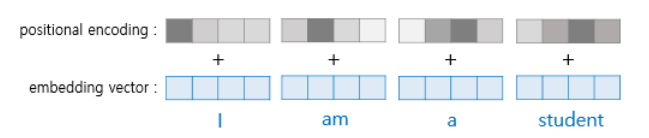

RNN에는 어차피 문장을 구성하는 단어들이 어순대로 모델에 입력되므로, 모델에게 따로 어순 정보를 알려줄 필요가 없었으나 문장에 있는 모든 단어를 한꺼번에 문장 단위로 입력받는 트랜스포머는 자칫 'I ate lunch'와 'lunch ate I'를 구분할 수 없음. 그래서 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는 것임.

#### Positional Encoding에 대한 이해

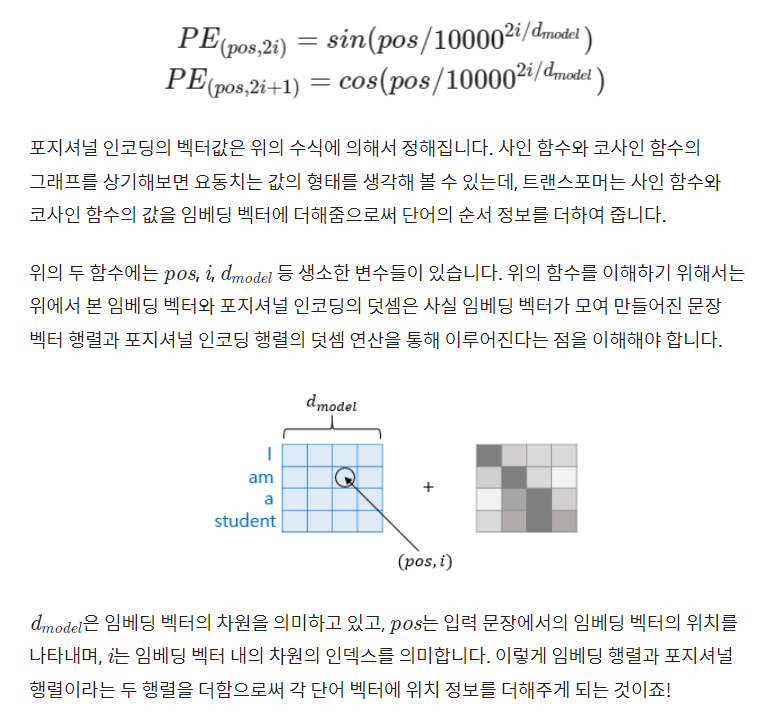

같은 단어라고 하더라도 포지셔널 인코딩을 해준 경우에는 임베딩 벡터값이 달라지므로, 같은 단어라고 해도 각각 다른 위치에 등장했다는 사실을 모델에 알려줄 수 있음

#### 기타 알게 된점

- tokenizer.encode(): 각 단어를 정수로 변환

- 교사 강요(teacher forcing)  테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법. 훈련할 때 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용
ex) what will the fat cat sit on라는 훈련 샘플이 있다면, what will the fat cat sit 시퀀스를 모델의 입력으로 넣으면, will the fat cat sit on를 예측하도록 훈련됨. (will, the, fat, cat, sit, on는 각 시점의 레이블)
->트랜스포머의 디코더에 적용되며, 자귀회귀모델(auto-regressive model, AR)를 포함함.

| 평가문항 | 상세기준 |
| :---: | :---: |
| 1. 한국어 전처리를 통해 학습 데이터셋을 구축하였다. | 공백과 특수문자 처리, 토크나이징, 병렬데이터 구축의 과정이 적절히 진행되었다. |
| 2. 트랜스포머 모델을 구현하여 한국어 챗봇 모델 학습을 정상적으로 진행하였다. | 구현한 트랜스포머 모델이 한국어 병렬 데이터 학습 시 안정적으로 수렴하였다. |
| 3. 한국어 입력문장에 대해 한국어로 답변하는 함수를 구현하였다. | 한국어 입력문장에 그럴듯한 한국어로 답변을 리턴하였다. |

## 라이브러리 Import

In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

## Step 1. 데이터 수집하기

In [2]:
data = os.getenv('HOME')+'/aiffel/transformer_chatbot/data/ChatbotData .csv'
chatbot_data = pd.read_csv(data)

In [3]:
chatbot_data

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [4]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


## Step 2. 데이터 전처리하기

정규 표현식(Regular Expression) 을 사용하여 구두점(punctuation) 을 제거하여 단어를 토크나이징(tokenizing) 하는 일에 방해가 되지 않도록 정제

In [5]:
# 전처리 함수
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()

    return sentence

In [6]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations(questions, answers):
    inputs, outputs = [], []
    
    for question, answer in zip(questions, answers):
        inputs.append(preprocess_sentence(question))
        outputs.append(preprocess_sentence(answer))
        
    return inputs, outputs

In [7]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장함.
questions, answers = load_conversations(chatbot_data['Q'], chatbot_data['A'])
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

# 질문과 답변은 병렬적으로 구성되는 데이터셋이므로 두 샘플 수는 정확하게 일치해야 합

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [8]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달에는 더 절약해봐요 .


- 단어장을 생성하고, 디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여
- TensorFlow Datasets SubwordTextEncoder를 토크나이저로 사용한다.  단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 정수로 인코딩한다.
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 START_TOKEN 및 END_TOKEN을 추가한다.
- 최대 길이 MAX_LENGTH인 40을 넘는 문장들은 필터링한다.
- MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 패딩 한다.
- 디코더의 입력과 실제값(레이블)을 정의해 주기 위해 교사강요 사용하기

## Step 3. SubwordTextEncoder 사용하기

In [10]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [11]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [12]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8173]
END_TOKEN의 번호 : [8174]


In [13]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8175


In [14]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5763, 610, 2492, 4164]
정수 인코딩 후의 21번째 답변 샘플: [2356, 7513, 7, 6276, 97, 1]


In [15]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

40


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8175
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성함. 이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

In [21]:
# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의

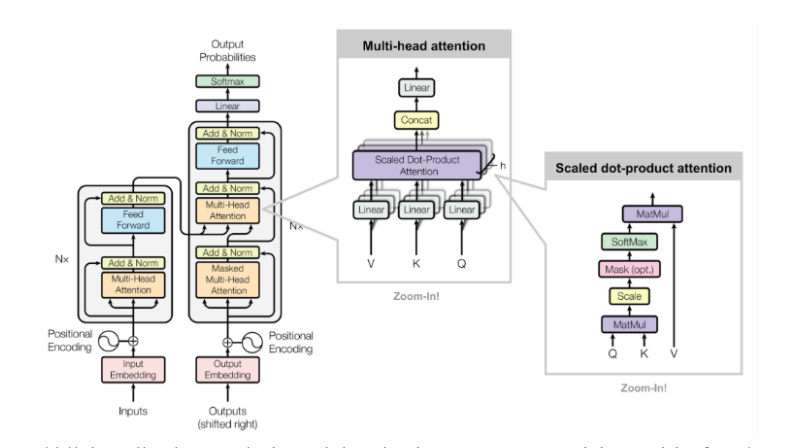

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


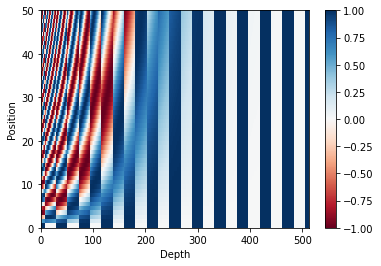

In [23]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [24]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## Multi-head Attention

- 어텐션을 위한 세가지 입력 요소(Query, key, Value)
- Query(Q) : 어떠한 단어가 다른 단어와 어떠한 연관성을 가지는지 물어보는 주체
- Key(K) : 물어보는 대상

- I am a stuent라는 문장이 있을 때, I 라는 단어가 Q고, i am a teacher 각  단어들이 K가 됨. 이 때 각각의 키에 대해서 어텐션 score를 구하게 되고. 그러고나서 score를 value를 곱하여 attention value를 구하게 됨.

- 물어보는 주체(Q)가 들어오고, 각각의 어텐션을 수행할 단어(K)가 들어와서 행렬곱하여 스켈링을 해주고, 필요한 경우 마스크 씌어주고, Softmax에서 각각의 K중에서 어떤단어와 가장 높은 연관성을 구하는지 확률을 구하게 됨.그 다음 Value값과 곱해서 가중치가 적용된 attention layer가 만들어짐. 이 과정들이 Scaled Dot-Product Attention에서 일어남.

- 문장이 입력되면 Q와 K로 구분되고 linear layer 즉, 행렬곱을 수행해서 , h계로 구분된서로다른 value와 key, query로 구분되도록 만듬 - 서로 다른 concept의 attention을 학습하도록 만들어서 다양한 특징을 학습하도록 만들어줌.여기서 h는 head의 갯수임.

- 위의 과정을 거치면 concat으로 모두 합치고 linear layer를 걸쳐 output값을 가지게됨.

- 결과적으로, 입력값과 출력값의 dimension이 같게 만들어서 multi-head attention을 사용한 후에도 dimension이 줄어들지 않도록 만듬

디코더의 encoder-decoder attention에서는 디코더의 출력단어가 쿼리가 되는 것이고, 각각 출력 단어를 만들기 위해서 인코더파트에서 어떤 단어를 참고하면 좋은지를 구하기위해서 이 k와 v의 값을 encoder의 출력값 사용함. = 어떠한 결과값을 가지기위해서 참고하기위해 인코더에게 물어보는 것임


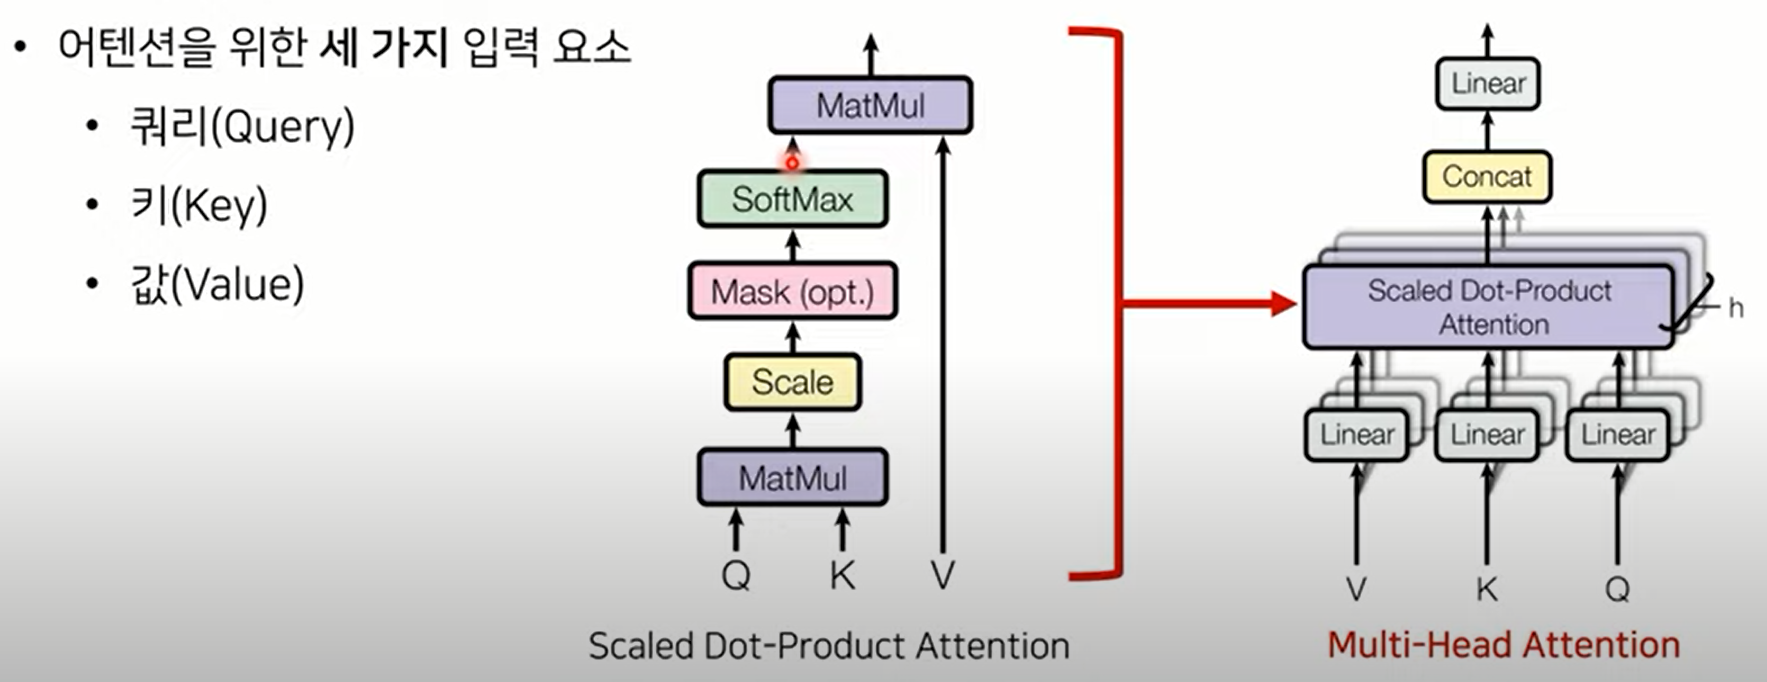

* 마스크 행렬(mask matrix) : 특정 단어는 무시할 수 있도록 하는데, 마스크 값으로 음수 무한의 값을 넣어 softmax함수의 출력이 0%에 가까워 지도록함.

예를 들어, Attention energies 값이 있을 때 이것과 같은 차원의 마스크 행렬을 만들어서 각각의 원소단위로 곱해주어 어떠한 단어는 참고하지 않도록 함.

I love you 라는 문장에서 "I"의 값이 열에 있는 "love you"는 무시하도록 하는 것(음수 무한의 값을 넣어 attention 하지않는것)

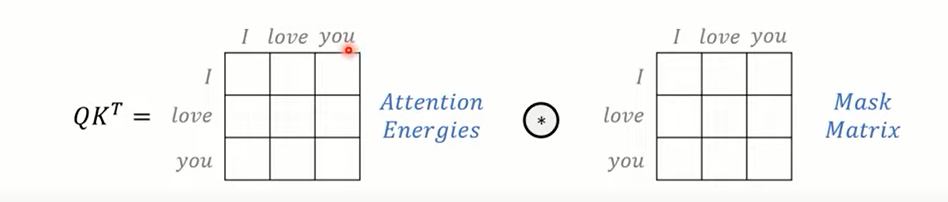

In [25]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

In [26]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [27]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


RNN은 step이라는 개념이 존재해서 각 step마다 단어가 순서대로 입력으로 들어가는 구조인 반면 트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있음. 그리고 이 특징 때문에 추가적인 마스킹(Masking) 을 필요함.

트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있음. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것이기에 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법임.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 함.

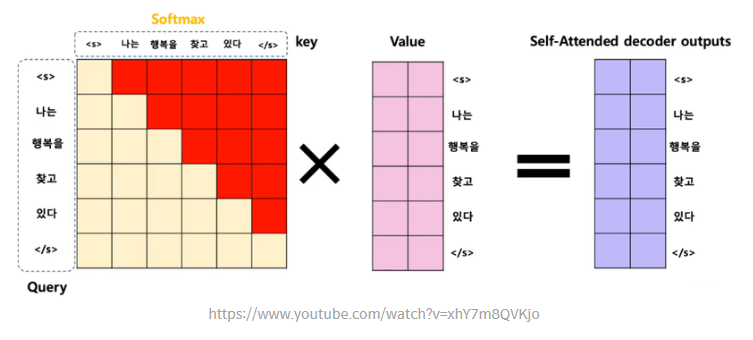

위의 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있음. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있음. (행을 Query, 열을 Key로 표현된 행렬)


예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 <'s'>, <나는>, <행복을>, <찾고>까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있음. 즉, 유사도를 구할 수 없도록 해놓는 것임.

In [28]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [29]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [30]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

tf.Tensor(
[[[[1. 1. 1. 1. 1.]
   [1. 0. 1. 1. 1.]
   [1. 0. 0. 1. 1.]
   [1. 0. 0. 0. 1.]
   [1. 0. 0. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


#### 인코더 형성

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어지며
(셀프 어텐션과 피드 포워드 신경망), 셀프 어텐션은 멀티 헤드 어텐션으로 병렬적으로 이루어 짐.

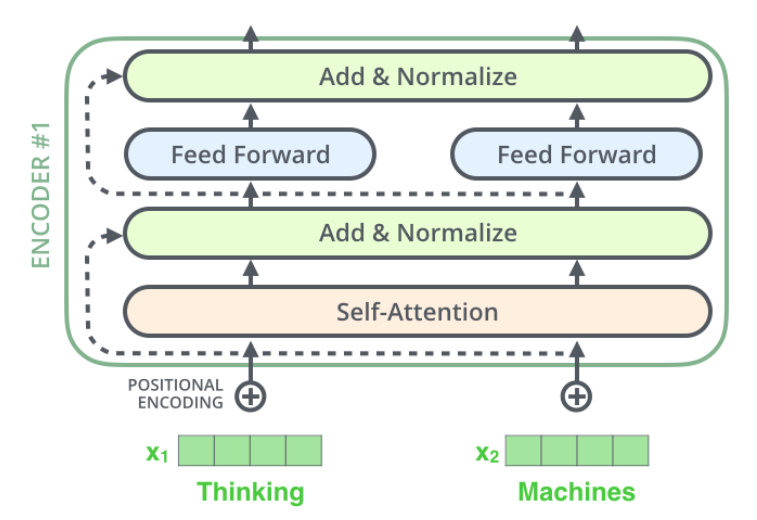

In [31]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [32]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

#### 디코더 형성

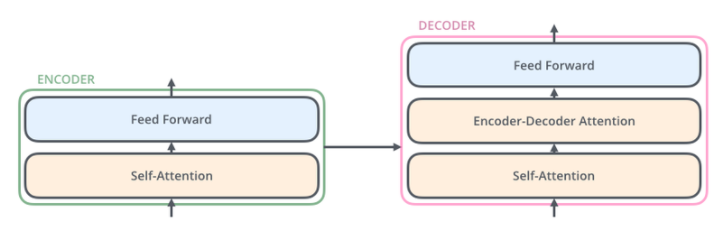

인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있음. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정임

인코더의 셀프 어텐션과 마찬가지로 디코더의 셀프 어텐션, 인코더-디코더 어텐션 두 개의 어텐션 모두 스케일드 닷 프로덕트 어텐션을 멀티 헤드 어텐션으로 병렬적으로 수행함.

In [33]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [34]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

In [35]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [36]:
## 모델 생성

tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 6 # 인코더와 디코더의 층의 개수
D_MODEL = 512 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    13653504    inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [37]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

#### 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용

In [38]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


Text(0.5, 0, 'Train Step')

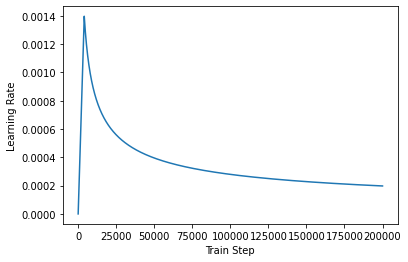

In [39]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 모델 컴파일 및 학습

In [40]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [41]:
EPOCHS = 50
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
185/185 [==============================] - 54s 207ms/step - loss: 1.3454 - accuracy: 0.0240
Epoch 2/50
185/185 [==============================] - 39s 211ms/step - loss: 1.0752 - accuracy: 0.0493
Epoch 3/50
185/185 [==============================] - 40s 214ms/step - loss: 0.9844 - accuracy: 0.0506
Epoch 4/50
185/185 [==============================] - 40s 217ms/step - loss: 0.9381 - accuracy: 0.0531
Epoch 5/50
185/185 [==============================] - 40s 219ms/step - loss: 0.9017 - accuracy: 0.0554
Epoch 6/50
185/185 [==============================] - 41s 220ms/step - loss: 0.8636 - accuracy: 0.0574
Epoch 7/50
185/185 [==============================] - 41s 222ms/step - loss: 0.8207 - accuracy: 0.0599
Epoch 8/50
185/185 [==============================] - 41s 222ms/step - loss: 0.7701 - accuracy: 0.0633
Epoch 9/50
185/185 [==============================] - 41s 222ms/step - loss: 0.7141 - accuracy: 0.0674
Epoch 10/50
185/185 [==============================] - 41s 222ms/step - l

## Step 5. 모델 평가하기

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거침
2. 입력 문장을 토크나이징하고, START_TOKEN과 END_TOKEN을 추가함.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산함.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측함.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용함.
6. END_TOKEN이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춤.

위의 과정을 모두 담은 decoder_inference() 함수를 만듬

In [42]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

decoder_inference() 함수를 호출하여 챗봇의 대답을 얻는 sentence_generation() 함수를 형성

In [43]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

In [46]:
sentence_generation("사랑이란 뭘까?")

입력 : 사랑이란 뭘까?
출력 : 사랑에는 답이 없어요 .


'사랑에는 답이 없어요 .'

## Report

트랜스포머를 활용하여 챗봇을 만들어 보았음.
자연어 처리에 있어서 아직 완벽한 이해를 하기에는 부족한 점이 많은 것 같아 반복 학습해야 될 것 같음.

## 참고 사이트
- https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/
- 트랜스포머 : https://nlpinkorean.github.io/illustrated-transformer/
- https://www.youtube.com/watch?v=AA621UofTUA&t=1696s